In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from imblearn.under_sampling import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

### The aim of this analysis is try to understand what factor that customers complain most toward a product and what other that customer think it is the benefits of the product.

In [2]:
data = pd.read_csv('data/GI_comment.csv')
data.head()

,Comment,Vote_useful,Date,Rating
0,The game in general is the best I've ever play...,32,"August 23, 2022",5
1,I absolutely love and adore this game. By far ...,643,"August 16, 2022",5
2,"It is amazing, I have only been playing it for...",396,"August 21, 2022",4
3,This game is truly amazing and getting better ...,188,"August 19, 2022",4
4,The release of Sumeru gave so much to do! I've...,91,"September 5, 2022",4


In [3]:
data.shape

(2040, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Comment      2040 non-null   object
 1   Vote_useful  2040 non-null   object
 2   Date         2040 non-null   object
 3   Rating       2040 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 63.9+ KB


# Preprocessing And Cleaning

In [5]:
data.isnull().sum()

Comment        0
Vote_useful    0
Date           0
Rating         0
dtype: int64

<font size="4">There are no null values</font>

In [6]:
index_dup = data.duplicated()
data[index_dup]

,Comment,Vote_useful,Date,Rating
896,"This game is really fun to play with, but I'm ...",0,"August 14, 2022",4


<font size="4">There are 1 duplicated row</font>

In [7]:
data = data.drop_duplicates()

## Process With Date Column

In [8]:
data['fixed_Date'] = pd.to_datetime(data['Date'])
data.head()

,Comment,Vote_useful,Date,Rating,fixed_Date
0,The game in general is the best I've ever play...,32,"August 23, 2022",5,2022-08-23
1,I absolutely love and adore this game. By far ...,643,"August 16, 2022",5,2022-08-16
2,"It is amazing, I have only been playing it for...",396,"August 21, 2022",4,2022-08-21
3,This game is truly amazing and getting better ...,188,"August 19, 2022",4,2022-08-19
4,The release of Sumeru gave so much to do! I've...,91,"September 5, 2022",4,2022-09-05


In [9]:
data = data.drop(columns=['Date'])
data.head()

,Comment,Vote_useful,Rating,fixed_Date
0,The game in general is the best I've ever play...,32,5,2022-08-23
1,I absolutely love and adore this game. By far ...,643,5,2022-08-16
2,"It is amazing, I have only been playing it for...",396,4,2022-08-21
3,This game is truly amazing and getting better ...,188,4,2022-08-19
4,The release of Sumeru gave so much to do! I've...,91,4,2022-09-05


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Comment      2039 non-null   object        
 1   Vote_useful  2039 non-null   object        
 2   Rating       2039 non-null   int64         
 3   fixed_Date   2039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 79.6+ KB


## Process With Vote_useful Column

In [11]:
for i in range(len(data.Vote_useful)):
    data.Vote_useful.iloc[i] = data.Vote_useful.iloc[i].replace(',', '')

c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
data.Vote_useful = data.Vote_useful.astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Comment      2039 non-null   object        
 1   Vote_useful  2039 non-null   int32         
 2   Rating       2039 non-null   int64         
 3   fixed_Date   2039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 71.7+ KB


## Process With Comment Column

### Remove  " ' " From String

In [13]:
for i in range(len(data.Comment)):
    data.Comment.iloc[i] = data.Comment.iloc[i].replace("'", "")
    data.Comment.iloc[i] = data.Comment.iloc[i].lower()

In [14]:
data.Comment.iloc[1]

'i absolutely love and adore this game. by far my favorite story roleplaying game out there. the quests, lore, plots, mysteries, grind, pulls, all of it. im a newer player, but i havent been bored yet of this game. i dont think i ever will. id say its biggest issues is lagging, and setting its quality different on its own. as well as occasional bugs on my laptop. if the frame per second(fps) could be a bit quicker that would be great. but other than that, the game is beautiful. will update.'

### Remove non character except for dots

In [15]:
lst_ = []
for i in data.Comment:
    clean_sample = re.sub(r"[^a-zA-Z0-9.]+", ' ', i)
    lst_.append(clean_sample)
data['fixed_Comment'] = lst_

### Remove Stopwords

In [16]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text_split = text.split()
    text = [word for word in text_split if word not in stop]
    return ' '.join(text)

data['fixed_Comment'] = data['fixed_Comment'].apply(remove_stopwords)

### Lematization

In [17]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v)
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN


def lemmatize_text(text):
    lemmatized = []
    post_tag_list = pos_tag(word_tokenize(text))
    for word, post_tag_val in post_tag_list:
        lemmatized.append(lemmatizer.lemmatize(word, get_wordnet_pos(post_tag_val)))
    text = ' '.join(x for x in lemmatized)
    return text
data['fixed_Comment'] = data['fixed_Comment'].apply(lemmatize_text)

> Each of review are seperated into 5 groups alias:

* Gameplay
* Graphics
* Music
* Storyline
* Gacha Mechanic
* Technical Issue

The Evaluation is seperated into three groups : Bad, Neutral, Good

Each of statements is divided with dots

I used a threhold to determine if that statement have good attitude or not

In [18]:
lst_technical = ['lag', 'bug', 'servers', 'connect', 'control', 'sync', 'glitch', 
                 'crash', 'hack', 'mobile', 'phone', 'pc', 'storage', 'space', 'fps', 
                'computer', 'laptop', 'log', 'frame' , 'linux', 'window', 'mac', 'android' 'batter', 
                 'heating', 'aim', 'ram', 'ping', 'performance', 'lan', 'loading', 'screen', 'button', 
                'dialogue', 'click', 'chrome', 'keyboard', 'mouse', 'touch', 'general']
lst_gameplay = ['adventure', 'fighting', 'experience', 'content', 'event', 'f2p', 'community', 'coop',
                'anniversary', 'screen', 'menu', 'rpg', 'rng', 'enemy', 'journey', 'open world', 'artifacts',
               'gameplay', 'dialogue', 'exploration', 'progression', 'puzzle', 'puzzles', 'artifacts', 
                'material', 'cliff', 'boss', 'mob', 'general']
lst_graphics = ['graphic', 'graphics', 'art', 'artwork', 'artworks', 'arts', 'scenery', 
                'sceneries' 'general']
lst_music = ['music', 'sound','sounds', 'soundtracks', 'soundtrack', 'general']
lst_storyline = ['story', 'stories', 'storyline', 'quests', 'quest', 'archon', 'character', 
                 'characters', 'lore', 'general']
lst_gacha = ['pitty', 'wishes', 'gacha', 'drop rate', 'rate', 'primo', 'pull', 'pulling', 'cash', 
             'money', 'dollar', 'spent', 'general']

### Using negative and positive list word

In [19]:
negative_file = open("data/sentiment/negative_words.txt", "r")
negative_list = negative_file.readlines()
for pos_word in range(len(negative_list)):
    negative_list[pos_word] = negative_list[pos_word].replace('\n', '')

In [20]:
positive_file = open("data/sentiment/positive_words.txt", "r")
positive_list = positive_file.readlines()
for pos_word in range(len(positive_list)):
    positive_list[pos_word] = positive_list[pos_word].replace('\n', '')

In [21]:
lst_graphics = ['graphic', 'graphics', 'art', 'artwork', 'artworks', 'arts', 'scenery', 
                'sceneries']
lst_music = ['music', 'sound','sounds', 'soundtracks', 'soundtrack']
lst_storyline = ['story', 'stories', 'storyline', 'quests', 'quest', 'archon', 'lore']
lst_gacha = ['pitty', 'wishes', 'gacha', 'drop', 'drops', 'rate', 'rates', 'rated', 'primo',
             'primogem', 'primogems', 'pull', 'pulling', 'cash', 'money', 'dollar', 'spent']

> In this function, I used to classify the attitude of a customer reviews toward each of fields as i mentioned above:
 * As there are 3 attitudes bad, neutral and good. Using the negative and positive words to determine.
 * Negative and positive ratio are calculated base on the number of negative and positive words in each of sentence, the formula is :
     * <i>negative_ratio = count_negative/(count_negative + count_positive + 1)</i>
     * <i>positive_ratio = count_positive/(count_negative + count_positive + 1)</i>
 * Now, it is clear that the bad and good attitude are easy to classify but what about neutral? So that I used another formula :
     * <i>abs((count_negative - count_positive)/(count_negative + count_positive + 1))</i>
       * From here, if the number of negative words is so close to the number of positive words then the formula above will give a very small number (less than 0.25 if there are only 1 negative word and two positive words or vice versa). So that, I only use a threshold ( It is 0.25 in the function ) to classify neutral attitude.
     

In [22]:
def process_sentence_prototype(lst_attitude, lst_field):
    for passage in data.fixed_Comment:
        index_sentence = 0
        flag_key_word = False
#------------------------------------------
        count_positive = 0
        count_negative = 0

        for sentence in passage.split('.'):
            for word in sentence.split(' '):
                if word != '':
                    if word in lst_field:
                        flag_key_word = True
                        check_sentence = passage.split('.')[index_sentence]
                        for check_word in check_sentence.split(' '):
                            if check_word in positive_list:
                                count_positive += 1
                            if check_word in negative_list:
                                count_negative += 1
                        break
            index_sentence += 1
#---------------------process sentiment--------------------------------
       
        negative_ratio = count_negative/(count_negative + count_positive + 1)
        positive_ratio = count_positive/(count_negative + count_positive + 1)

        if (abs((count_negative - count_positive)/(count_negative + count_positive + 1)) <= 0.25):
                lst_attitude.append('neutral')
        else:
            if(negative_ratio > positive_ratio):
                lst_attitude.append('bad')
                
            elif (negative_ratio <= positive_ratio):
                lst_attitude.append('good')


### Processing sentiment

In [23]:
lst_technical_mention = []
lst_technical_attitude = []
lst_gameplay_mention = []
lst_gameplay_attitude = []
lst_graphics_mention = []
lst_graphics_attitude = []
lst_music_mention = []
lst_music_attitude = []
lst_storyline_mention = []
lst_storyline_attitude = []
lst_gacha_mention = []
lst_gacha_attitude = []

process_sentence_prototype(lst_technical_attitude, lst_technical)
process_sentence_prototype(lst_gameplay_attitude, lst_gameplay)
process_sentence_prototype(lst_graphics_attitude, lst_graphics)
process_sentence_prototype(lst_music_attitude, lst_music)
process_sentence_prototype(lst_storyline_attitude, lst_storyline)
process_sentence_prototype(lst_gacha_attitude, lst_gacha)

In [24]:
df = data[['fixed_Comment']]
df['Attitude_technical'] = lst_technical_attitude
df['Attitude_gameplay'] = lst_gameplay_attitude
df['Attitude_graphics'] = lst_graphics_attitude
df['Attitude_music'] = lst_music_attitude
df['Attitude_storyline'] = lst_storyline_attitude
df['Attitude_gacha'] = lst_gacha_attitude
df.head()

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_11868/487282668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Attitude_technical'] = lst_technical_attitude
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_11868/487282668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Attitude_gameplay'] = lst_gameplay_attitude
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_11868/487282668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,fixed_Comment,Attitude_technical,Attitude_gameplay,Attitude_graphics,Attitude_music,Attitude_storyline,Attitude_gacha
0,game general best ive ever play term adventure...,good,good,good,neutral,neutral,neutral
1,absolutely love adore game . far favorite stor...,neutral,neutral,neutral,neutral,neutral,neutral
2,amaze play day lag lot might becuse storage ne...,neutral,neutral,neutral,neutral,neutral,neutral
3,game truly amaze get well day day though many ...,neutral,neutral,neutral,neutral,neutral,neutral
4,release sumeru give much ive playing year . ge...,neutral,bad,good,neutral,neutral,neutral


### Visualization

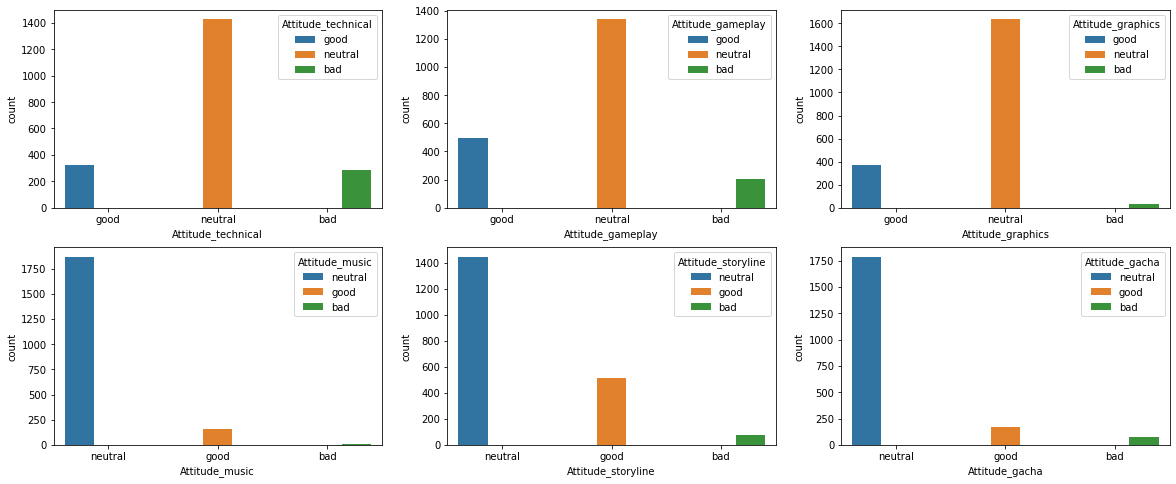

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(20,8))
sns.countplot(ax=axs[0, 0], data=df, x='Attitude_technical', hue='Attitude_technical')
sns.countplot(ax=axs[0, 1], data=df, x='Attitude_gameplay', hue='Attitude_gameplay')
sns.countplot(ax=axs[0, 2], data=df, x='Attitude_graphics', hue='Attitude_graphics')
sns.countplot(ax=axs[1, 0], data=df, x='Attitude_music', hue='Attitude_music')
sns.countplot(ax=axs[1, 1], data=df, x='Attitude_storyline', hue='Attitude_storyline')
sns.countplot(ax=axs[1, 2], data=df, x='Attitude_gacha', hue='Attitude_gacha');

> The idea to evaluate is base on the portion of bad attitude with good attitude if bad attitude take over a threshold (I used 0.4) then that field has bad attitude from the customers.
   
   * As from here, I can easy understand that graphics music and storyline are the good ones, because of significant larger portion good attitude than the bad attitude

In [26]:
df_technical = df.groupby(['Attitude_technical'])['Attitude_technical'].count().to_frame()
df_gameplay = df.groupby(['Attitude_gameplay'])['Attitude_gameplay'].count().to_frame()
df_graphics = df.groupby(['Attitude_graphics'])['Attitude_graphics'].count().to_frame()
df_music = df.groupby(['Attitude_music'])['Attitude_music'].count().to_frame()
df_storyline = df.groupby(['Attitude_storyline'])['Attitude_storyline'].count().to_frame()
df_gacha = df.groupby(['Attitude_gacha'])['Attitude_gacha'].count().to_frame()

* Here is how I perform the evaluation, Threshold ( conf ) : 0.4

In [27]:
lst_df = [df_technical, df_gameplay, df_graphics, df_music, df_storyline, df_gacha]
lst_df_bad = []
lst_df_good = []
conf = 0.4
for item in lst_df:
    item_conf = item.iloc[0] / item.iloc[1]
    if (item_conf[0] >= conf):
        lst_df_bad.append(item.columns[0])
    else:
        lst_df_good.append(item.columns[0])

In [28]:
print('List of bad attitude fields: ', lst_df_bad)
print('List of good attitude fields: ', lst_df_good)

List of bad attitude fields:  ['Attitude_technical', 'Attitude_gameplay', 'Attitude_gacha']
List of good attitude fields:  ['Attitude_graphics', 'Attitude_music', 'Attitude_storyline']


* It is clear that most of people have good attitude with the music, storyline and graphics of the product.
* As for technical issues, gacha mechanic and gameplay problems can be seen as the most complained ones

### ... May Work more